In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# from skimage.metrics import structural_similarity as ssim
# from data.loaders.OnlineLoader import OnlineRedWeb
from data.loaders.DataLoader import RedWebDataset , Rescale,RandomCrop, ToTensor

/Users/adi/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/adi/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/adi/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <42C20470-F879-3070-BF42-74C7B230A1A1> /Users/adi/opt/anaconda3/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
normal_dataset = RedWebDataset(root_dir="../data/ReDWeb_V1",transform=transforms.Compose([
    Rescale(256),
    RandomCrop(225),
    ToTensor()
]))
batcher = DataLoader(normal_dataset,batch_size=1,shuffle=True)

In [3]:
for sample1 in batcher:
    print(sample1["mono"].shape)
    print(sample1["heat"].shape)
    break

for sample2 in batcher:
    print(sample2["mono"].shape)
    print(sample2["heat"].shape)
    break


torch.Size([1, 3, 225, 225])
torch.Size([1, 3, 225, 225])
torch.Size([1, 3, 225, 225])
torch.Size([1, 3, 225, 225])


/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_94717/2951813992.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  ax["A"].imshow(sample1["mono"][0].T)


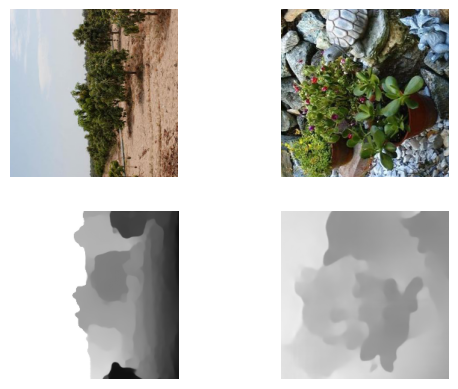

In [4]:
import matplotlib.pyplot as plt
fig ,ax = plt.subplot_mosaic("AB;CD")
ax["A"].imshow(sample1["mono"][0].T)
ax["C"].imshow(sample1["heat"][0].T)


ax["B"].imshow(sample2["mono"][0].T)
ax["D"].imshow(sample2["heat"][0].T)

for k in ax.keys():
    ax[k].axis("off")
    ax[k].grid("off")


In [5]:

def gaussian(window_size, sigma):
    gauss = torch.exp(-(torch.arange(window_size) - window_size // 2)**2 / (2.0 * sigma**2))
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.register_buffer('window', create_window(window_size, self.channel))

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.type() == img1.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            window = window.to(img1.device).type_as(img1)
            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    window = window.to(img1.device).type_as(img1)
    return _ssim(img1, img2, window, window_size, channel, size_average)


In [6]:
ssim_loss = SSIM()

In [7]:
ssim_loss(sample1["mono"],sample1["heat"])

tensor(0.9881, dtype=torch.float64)

In [8]:
ssim_loss(sample2["mono"],sample2["heat"])

tensor(0.9762, dtype=torch.float64)